In [9]:
from langchain_openai import chat_models,ChatOpenAI
from langgraph.graph import StateGraph,START ,END
from typing import TypedDict , Annotated,Literal
from langchain_core.messages import SystemMessage, HumanMessage

In [8]:
generatorllm=ChatOpenAI(model="gpt-4o")
evalautor_llm=ChatOpenAI(model="gpt-4o-mini")
optimizer_llm=ChatOpenAI(model='gpt-4o')

In [14]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [16]:
structured_evaluator_llm = evalautor_llm.with_structured_output(TweetEvaluation)

In [12]:
#state

class tweetstate(TypedDict):
    topic:str
    tweet:str
    evluation:Literal["approved","needs_improvement"]
    feedback:str
    iteration:int
    max_iteration:int



In [22]:
def generate_tweet(state: tweetstate):

    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    # send generator_llm
    response = generatorllm.invoke(messages).content

    # return response
    return {'tweet': response, 'tweet_history': [response]}

In [21]:
def evaluate_tweet(state: tweetstate):

    # prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]

    response = structured_evaluator_llm.invoke(messages)

    return {'evaluation':response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [20]:
def optimize_tweet(state: tweetstate):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}


In [25]:
def route(state:tweetstate):
    if state['evluation'] =='approved' or state['iteration']>=state['max_iteration']:
        return 'approved'
    else:
        return 'needs_mprovements'

In [29]:
graph=StateGraph(tweetstate)

graph.add_node('generate',generate_tweet)
graph.add_node('evaluate',evaluate_tweet)
graph.add_node('optimizer',optimize_tweet)


graph.add_edge(START , 'generate')
graph.add_edge('generate','evaluate')
graph.add_conditional_edges('evaluate', route , {'approved':END, 'needs_improvements':'optimizer'})
graph.add_edge('optimizer','evaluate')
workflow=graph.compile()


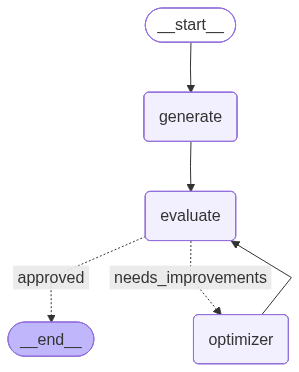

In [30]:
workflow

In [31]:
intial_state={
    'topic':"nepal airways",
    "iteration":1,
    "max_iteration":5
}

In [ ]:
workflow.invoke(intial_state)